In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(0)
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

sns.set_context('paper', font_scale=2)
sns.set_palette('Dark2')

/Users/tillbergmann/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Data Generation

We first generate same documents, using the examples in Steyvers & Griffits, 2007.

In [3]:
vocab = ["money",
        "loan",
        "bank",
        "river",
        "stream"]

We use two topics, where the term distributions are different, and then generate some documents from those distributions:

In [4]:
z_1 = np.array([1/3, 1/3, 1/3, .0, .0])
z_2 = np.array([.0, .0,1/3, 1/3, 1/3])

In [5]:
phi_actual = np.array([z_1, z_2]).T.reshape(len(z_2), 2)
phi_actual

array([[ 0.33333333,  0.        ],
       [ 0.33333333,  0.        ],
       [ 0.33333333,  0.33333333],
       [ 0.        ,  0.33333333],
       [ 0.        ,  0.33333333]])

In [6]:
# number of documents
D = 16
# mean word length of documents
mean_length = 10
# sample a length for each document using Poisson
len_doc = np.random.poisson(mean_length, size=D)
# fix number of topics
T = 2

In [7]:
docs = []
orig_topics = []
for i in range(D):
    z = np.random.randint(0, 2)
    if z == 0:
        words = np.random.choice(vocab, size=(len_doc[i]),p=z_1).tolist()
    else:
        words = np.random.choice(vocab, size=(len_doc[i]),p=z_2).tolist()
    orig_topics.append(z)
    docs.append(words)

The documents generated by the above procedure:

In [10]:
for doc in docs:
    print(" ".join(doc)+'.',)

loan bank loan money money loan bank loan loan bank.
money loan money money money loan money money loan bank money.
bank bank bank loan money loan money loan bank.
bank bank bank river bank stream river bank river.
stream bank bank bank stream river stream bank river river bank river bank river stream bank river stream.
river river bank stream river stream stream bank stream river stream river stream.
river river river bank.
loan loan money money loan money loan loan money money.
river river bank stream bank bank bank bank stream bank.
stream bank stream stream stream bank stream bank.
bank stream stream river bank bank stream river river bank.
stream stream bank river stream bank river bank bank bank stream.
stream stream river river stream river bank stream stream bank stream stream stream stream river bank.
money bank bank loan money money money loan money.
bank loan loan bank bank loan bank loan bank loan loan bank.
money bank money loan loan bank loan bank money bank money bank.


In [11]:
# topics we drew the words from 
# (in actual LDA this  would be a mixture of topics)
orig_topics

[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0]

# Init variables

First we initialize all our variables.

Here is what we need:

* i = just an index for all tokens
* w_i = index pointing to the raw word in the vocab
* d_i = index that tells you which document i belongs to 
* z_i = index that tells you what the topic assignment is for i

In [12]:
w_i = []
i = []
d_i = []
z_i = []
counter = 0

# go through each document
for doc_idx, doc in enumerate(docs):
    # go through each word in doc
    for word_idx, word in enumerate(doc):
        # pointer to word in vocab
        w_i.append(np.where(np.array(vocab)==word)[0][0])
        # counter
        i.append(counter)
        # pointer to which document it belongs to
        d_i.append(doc_idx)
        # initialize some topic assignment
        z_i.append(np.random.randint(0, T))
        counter += 1

# convert everything to numpy
w_i = np.array(w_i)
d_i = np.array(d_i)
z_i = np.array(z_i)

Then we can initialize our count matrices $C^{WT}$ and $C^{DT}$:

In [13]:
WT = np.zeros((len(vocab),T))
for idx, word_ in enumerate(vocab):
    topics = z_i[np.where(w_i == idx)]
    for t in range(T):
        WT[idx,t] = sum(topics == t)
        

DT = np.zeros((D,T))
for idx, doc_ in enumerate(range(D)):
    topics = z_i[np.where(d_i == idx)]
    for t in range(T):
        DT[idx,t] = sum(topics == t)

In [14]:
# distribution for each word
WT_orig = WT.copy()
WT_orig

array([[ 11.,  14.],
       [ 20.,   7.],
       [ 29.,  28.],
       [ 11.,  17.],
       [ 18.,  17.]])

In [15]:
# distributioni for each document
DT_orig = DT.copy()
DT

array([[  8.,   2.],
       [  6.,   5.],
       [  3.,   6.],
       [  5.,   4.],
       [  8.,  10.],
       [  8.,   5.],
       [  2.,   2.],
       [  7.,   3.],
       [  4.,   6.],
       [  6.,   2.],
       [  5.,   5.],
       [  2.,   9.],
       [  8.,   8.],
       [  6.,   3.],
       [  5.,   7.],
       [  6.,   6.]])

# Gibbs sampling

We can now run `iters` Gibbs iterations. In each step, we cycle through each word token, and update its topic assignment $z_i$ given the formula in Steyvers.

In [16]:
phi_1 = np.zeros((len(vocab),100))
phi_2 = np.zeros((len(vocab),100))

In [17]:
iters = 100
beta = 1.
alpha = 1.

for step in range(iters):
    for current in i:
        # get indices
        doc_idx = d_i[current]
        w_idx = w_i[current]
        
        # get slice of WT and DT
        tmp_WT = WT[w_idx,:]
        tmp_DT = DT[doc_idx,:]
        
        # decrease count matrices
        DT[doc_idx,z_i[current]] -= 1
        WT[w_idx,z_i[current]] -= 1
        
        # calculate new assignment 
        prob_word =  (WT[w_idx,:] + beta) / (WT[:,:].sum(axis=0) + len(vocab)* beta)
        prob_document = (DT[doc_idx,:] + alpha) / (DT.sum(axis=0) + D*alpha)
        prob = prob_word * prob_document
        #update z_i
        z_i[current] = np.random.choice([0,1], 1, p=prob/prob.sum())[0]
#         z_i[current] = np.random.multinomial(1, prob/prob.sum()).argmax()
        # update count matrices
        DT[doc_idx,z_i[current]] += 1
        WT[w_idx,z_i[current]] += 1
        
        # track phi
        phi  = WT/(WT.sum(axis=0))
        phi_1[:,step] = phi[:,0]
        phi_2[:,step] = phi[:,1]

## Examine final count matrices

In [18]:
# New counts:
DT

array([[ 10.,   0.],
       [ 11.,   0.],
       [  9.,   0.],
       [  1.,   8.],
       [  1.,  17.],
       [  0.,  13.],
       [  1.,   3.],
       [ 10.,   0.],
       [  2.,   8.],
       [  0.,   8.],
       [  0.,  10.],
       [  1.,  10.],
       [  0.,  16.],
       [  9.,   0.],
       [ 12.,   0.],
       [ 12.,   0.]])

In [19]:
WT

array([[ 25.,   0.],
       [ 27.,   0.],
       [ 27.,  30.],
       [  0.,  28.],
       [  0.,  35.]])

## Calculate posteriors

Now we can use the other formulaes to calculate posteriors $\phi$ and $\theta$. First, let's calculate phi and and theta:

In [20]:
phi  = WT/(WT.sum(axis=0))
phi

array([[ 0.3164557 ,  0.        ],
       [ 0.34177215,  0.        ],
       [ 0.34177215,  0.32258065],
       [ 0.        ,  0.30107527],
       [ 0.        ,  0.37634409]])

In [21]:
theta  = DT/(DT.sum(axis=0))
theta = theta/np.sum(theta, axis=1).reshape(16,1)
theta

array([[ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.12827586,  0.87172414],
       [ 0.06476323,  0.93523677],
       [ 0.        ,  1.        ],
       [ 0.28181818,  0.71818182],
       [ 1.        ,  0.        ],
       [ 0.22738386,  0.77261614],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.10532276,  0.89467724],
       [ 0.        ,  1.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ]])

In [22]:
# Topics assigned to documents get the original document
np.argmax(theta, axis=1) == orig_topics

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True], dtype=bool)

## Plot Results

We can also plot these results. The first plot shows the probability of a word assigned to a topic over iterations. The first 20 iterations here are plotted, and we can see that the distributions settle relatively quickly around their final probabilities.

The second plot shows a visualization of $\phi$. The original, generated $\phi$ matrix is shown, then the matrix at the beginning of the Gibbs sampling (which is random), and then $\phi$ after running Gibbs. 

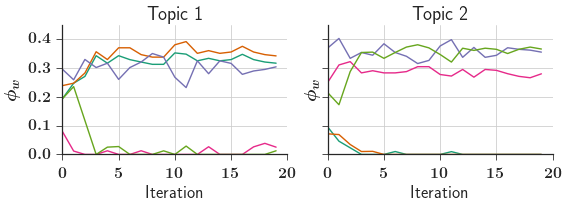

In [23]:

fig, axs = plt.subplots(1, 2, sharey=True)

for i in range(phi_1.shape[0]):
    axs[0].plot(phi_1[i,:20])
    axs[0].set_title('Topic 1')
    
for i in range(phi_2.shape[0]):
    axs[1].plot(phi_2[i,:20])
    axs[1].set_title('Topic 2')
    
fig.set_size_inches((8, 3))
sns.despine()

for ax in axs:
    ax.set_ylabel(r'$\phi_w$')
    ax.set_xlabel('Iteration')
    ax.set_yticks(np.arange(0, 0.5, 0.1))
    
fig.tight_layout()
# fig.savefig('phi_over_time.png', dpi=300)

In [24]:
phi_orig  = WT_orig/(WT_orig.sum(axis=0))
phi_orig

array([[ 0.12359551,  0.1686747 ],
       [ 0.2247191 ,  0.08433735],
       [ 0.3258427 ,  0.3373494 ],
       [ 0.12359551,  0.20481928],
       [ 0.20224719,  0.20481928]])

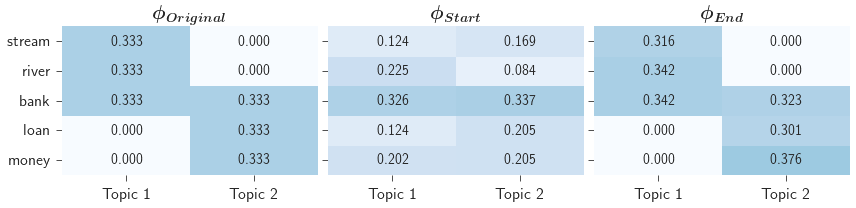

In [25]:
fig, axs = plt.subplots(1, 3, sharey=True)
# with sns.axes_style("white"):
sns.heatmap(phi_actual, vmin=0, vmax=1, cmap='Blues', ax=axs[0], cbar=False, annot=True, fmt=".3f", annot_kws={"size": 14})
axs[0].set_title(r"$\phi_{Original}$")
sns.heatmap(phi_orig, vmin=0, vmax=1, cmap='Blues', ax=axs[1], cbar=False, annot=True, fmt=".3f", annot_kws={"size": 14})
axs[1].set_title(r"$\phi_{Start}$")
sns.heatmap(phi, vmin=0, vmax=1, cmap='Blues', ax=axs[2], cbar=False, annot=True, fmt=".3f", annot_kws={"size": 14})
axs[2].set_title(r"$\phi_{End}$")


fig.set_size_inches((12, 3))

for ax in axs:
    ax.set_xticklabels(['Topic 1', 'Topic 2'])
    ax.set_yticklabels(vocab, rotation=360)

fig.tight_layout()
# fig.savefig('phi_start_end.png', dpi=300)

In [48]:
!pip freeze | grep 'seaborn\|matplotlib\|numpy'

matplotlib==1.5.1
numpy==1.10.4
seaborn==0.7.0
